# Collaborator 5 - Validation & Model Selection. 

This notebook aims to validate and select the most appropiate predictive model among the 16 candidates proposed to estimate the 10-year risk of coronary heart disease (CHD). All models proposed are evaluated using a 5-fold cross-validation, and five key metrics are used (Accuracy, Sensitivity, Precision, F1 and ROC-AUC) in order to analyse the overall performance and to select the best-performing model. 


### 1. Importation of the different librarys that will be used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib
import json

seed = 42

### 2. Data & Models used.
Here the data used and the different models generated are defined with the final parameters. 

In [27]:
df = pd.read_csv("../data/cleaned_df.csv")  
target = "ten_year_chd"
X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((3656, 16), (3656,))

##### Logistic Regression Models.

In [3]:
models_logistic = {
    "LR_C01": LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000), # less regularization
    "LR_C10": LogisticRegression(C=10, class_weight='balanced', max_iter=1000), # more regularization
    "LR_Hard_Penalization": LogisticRegression(class_weight={0: 1, 1: 10}, max_iter=1000), # hard penalization on positive class
    "LR_Liblinear": LogisticRegression(solver='liblinear', class_weight='balanced') # different solver
}

##### Random Forest Models.

In [4]:
models_rf = {
    "RF_Balanced": RandomForestClassifier(class_weight='balanced', random_state=42), # balanced classes
    "RF_Balanced_Subsample": RandomForestClassifier(class_weight='balanced_subsample', random_state=42), # balanced per bootstrap sample
    "RF_Limited_Depth": RandomForestClassifier(max_depth=5, class_weight='balanced', random_state=42), # limit depth to reduce overfitting
    "RF_More_Trees": RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42) # more trees
}

##### SVM Models.

In [5]:
models_svm = {
    "SVM_RBF_Standard": SVC(kernel='rbf', class_weight='balanced', probability=True), # standard RBF kernel
    "SVM_Linear": SVC(kernel='linear', class_weight='balanced', probability=True), # linear kernel
    "SVM_Polynomial": SVC(kernel='poly', degree=3, class_weight='balanced', probability=True), # polynomial kernel
    "SVM_C_High": SVC(C=10, class_weight='balanced', probability=True) # high C value for less regularization
}

##### KNN Models.

In [6]:
models_knn = {
    "KNN_3": KNeighborsClassifier(n_neighbors=3), # number of neighbors = 3
    "KNN_7": KNeighborsClassifier(n_neighbors=7), # number of neighbors = 7
    "KNN_Weight_Distance": KNeighborsClassifier(n_neighbors=5, weights='distance'), # weight by distance
    "KNN_Algorithm_BallTree": KNeighborsClassifier(algorithm='ball_tree') ## algorithm choice
}

### 3. Validation Startegy.

This section evaluates all candidate models using the same validation framework to ensure a comparable assessment of their performance. A 5‑fold stratified cross‑validation procedure is applied on the full dataset, using the binary target variable `ten_year_chd` (1 = CHD within 10 years, 0 = no CHD). In each fold, the data are split into training and validation subsets while preserving the original class distribution, the model is trained on the training portion and evaluated on the corresponding validation portion. The predictions from all folds are then aggregated to compute global performance metrics for each model.

For each configuration the following metric will be obtained: 
- **Accuracy**: proportion of correct predictions among all the predictions made.
- **Recall (Sensitivity)**:  proportion of actual positive cases that are correctly identified as positive (also call true positive rate).
- **Precision (Positive Class)**: proportion of predicted positives cases that are actually positive.
- **F1-score**: harmonnic mean between precision and recall for the positive class. 
- **ROC-AUC**: summarising the model's ability to distinguish between positive and negative classes across all classification thresholds.

This common validation strategy allows a consistent comparison of all models and supports the selection of the most appropriate one. Having in mind the preventive nature of a predictive model like this one, the main objective is to correctly identify patients at high risk of developing CHD (prioritising high recall), while maintaining a reasonable level of false positives (acceptable precision and F1-score). So, the final selection is based on a balance between Recall, F1-score, and ROC-AUC, rather than only on accuracy. 

To optimise the analysis, the evaluation will be made first accross each model family (Logistic Regression, Random Forest, SVM and KNN) and then across the best performing models. 

In [7]:
def evaluate_model_cv(model, X, y, cv=5): #the fuction will receive the model to evaluate, the data ( X and y) and the number of folds
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed) #divide the data into the different sections
    y_prob = cross_val_predict(model, X, y, cv = kf, method='predict_proba')[:,1] #train the model cv-times each time test in the remaining part
    y_pred = (y_prob >= 0.5).astype(int) #determine 0 or 1 based on the probability obtained

    acc = accuracy_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y,y_pred, zero_division=0)
    f1 = f1_score(y,y_pred)
    auc = roc_auc_score(y, y_prob)
    
    return acc, rec, prec, f1, auc #returns all the metrics

#### Logistic Regression Models Comparison.

In [8]:
results_logistic = []

for name, model in models_logistic.items():
    acc, rec, prec, f1, auc = evaluate_model_cv(model, X, y, cv=5)
    results_logistic.append({
        "model": name,
        "accuracy": acc,
        "recall": rec,
        "precision": prec,
        "F1-score": f1,
        "roc_auc": auc,})

results_logistic = pd.DataFrame(results_logistic)
results_logistic

,model,accuracy,recall,precision,F1-score,roc_auc
0,LR_C01,0.674234,0.664273,0.269287,0.383221,0.727306
1,LR_C10,0.672593,0.662478,0.267779,0.381395,0.725980
2,LR_Hard_Penalization,0.506291,0.850987,0.215847,0.344352,0.725509
3,LR_Liblinear,0.672593,0.662478,0.267779,0.381395,0.726252


All the four configurations of the Logistic Regression family show a reasonable ability to identify future CHD cases. The three balanced models (LR_C01, LR_C10 and LR_Liblinear) obtained very similar metrics, with accuracy around 0.67, recall ≈ 0.66, precision ≈ 0.27, F1-scores ≈ 0.38 and ROC-AUC ≈ 0.73. This values indicate that this models correctly identify a substantial proprotion of future cases, while keeping an acceptable rate of false positives, with a good general discriminative ability. 

In contrast, the LR_Hard_Penalization model, that increases the weigth of the positive class, has a higher recall (≈ 0.85) but sacrifice the accuracy (≈0.51) and precision (≈0.22), so a lower F1-scores is obtained. Finally, the ROC-AUC is comparable across the four models. This model, is at the end, more aggressive, and maximise sensitivity, but at the cost of creating more false alarm. 

#### Random Forest Comparison.

In [9]:
results_rf = []

for name, model in models_rf.items():
    acc, rec, prec, f1, auc = evaluate_model_cv(model, X, y, cv=5)
    results_rf.append({
        "model": name,
        "accuracy": acc,
        "recall": rec,
        "precision": prec,
        "F1-score": f1,
        "roc_auc": auc,})

results_rf = pd.DataFrame(results_rf)
results_rf

,model,accuracy,recall,precision,F1-score,roc_auc
0,RF_Balanced,0.847374,0.041293,0.489362,0.076159,0.686498
1,RF_Balanced_Subsample,0.847374,0.037702,0.488372,0.070000,0.684066
2,RF_Limited_Depth,0.717724,0.563734,0.284678,0.378313,0.712403
3,RF_More_Trees,0.847101,0.030521,0.472222,0.057336,0.692011


In the Random Forest family, three of the configurations (RF_Balanced, RF_Balanced_Subsample and RF_More_Trees) obtained high overall accuracy (≈ 0.85) and a reasonable precision, but with an extremly low recall value, therefore the F1-scores is also low. This models fails to detect the vast majority of positive cases.  

In contrast, the RF_Limited_Depth model has a more balanced behaviour, while having a lower accuracy (≈ 0.72) but with a higher recall (≈ 0.56) and moderate precision, with a final F1-scores of around 0.38 and a ROC-AUC of 0.71. Therefore, this model is the best of the Random Forest configuration, since it offers a more balance performance 

#### SVM Comparison.

In [10]:
results_svm = []

for name, model in models_svm.items():
    acc, rec, prec, f1, auc = evaluate_model_cv(model, X, y, cv=5)
    results_svm.append({
        "model": name,
        "accuracy": acc,
        "recall": rec,
        "precision": prec,
        "F1-score": f1,
        "roc_auc": auc,})

results_svm = pd.DataFrame(results_svm)
results_svm

,model,accuracy,recall,precision,F1-score,roc_auc
0,SVM_RBF_Standard,0.847648,0.003591,0.500000,0.007130,0.699889
1,SVM_Linear,0.851751,0.041293,0.741935,0.078231,0.724017
2,SVM_Polynomial,0.847648,0.025135,0.500000,0.047863,0.677542
3,SVM_C_High,0.847921,0.001795,1.000000,0.003584,0.615751


All the SVM models perform poorly in terms of correctly identifying future CHD cases. While all of them achieved high overall accuracy (≈ 0.85) and moderate ROC-AUC, tehir recall and F1-scores for the positive class are extremely low. The sensitivity remains close to zero, meaning that the vast majority of the patients that develop CHD in the future were classified as non-CHD. This may be due to the threshold of 0.5 stablished on the predicted probabilities or to the strong class imbalance in the dataset. As a conclusion, non of the SVM models i suitable for the prediction task. 

#### KNN Comparison.

In [11]:
results_knn = []

for name, model in models_knn.items():
    acc, rec, prec, f1, auc = evaluate_model_cv(model, X, y, cv=5)
    results_knn.append({
        "model": name,
        "accuracy": acc,
        "recall": rec,
        "precision": prec,
        "F1-score": f1,
        "roc_auc": auc,})

results_knn = pd.DataFrame(results_knn)
results_knn

,model,accuracy,recall,precision,F1-score,roc_auc
0,KNN_3,0.821389,0.129264,0.300000,0.180678,0.604869
1,KNN_7,0.840263,0.077199,0.380531,0.128358,0.654779
2,KNN_Weight_Distance,0.829869,0.066427,0.266187,0.106322,0.635480
3,KNN_Algorithm_BallTree,0.829869,0.064632,0.262774,0.103746,0.632968


In general, the K-Nearest Neighbours (KNN) models obtained a good overall accuracy (≈0.82-0.84) and ROC-AUC values, bute their recall and F1-scores for the positive class are extremely low. For the four configurations the recall is ranged between 0.06 to 0.13, and F1-scores are below 0.2. This indicates that these models do not classify correctly the patients that will develop CHD. Again, this behaviour is consitent with the strong class imbalance in the dataset, as KNN tends to favour the majority class. As a consequence, non of these models is sufficiently sensitive for the intended predictive model, and will not be consider as candidates.

### 4. Final Model Selection

Based on the prevoius analysis made by blocks, SVM and KNN models were discarded due to the extremely low recall and F1-scores values. From the Random Forest family, only the RF_Limited_Depth_ configuration provides acceptable metrics, and will be consider for the final selection. All four variants from the Logistic Regression (LR_C01, LR_C10, LR_Liblinear and LR_Hard_Penalization) showed strong performance, with suitable values of recall and F1-scores. Therefore, the final selection will only compare the four logistic regresion models and RF_Limited_Depth. 

As mentioned before, given the predictive and preventive nature of the model, the selection is based primarily on the performance of the positive class. The main objective is to correctly identify patients at high risk of developing CHD (high Recall), while maintaining an acceptable balance between false positives and false negatives (F1‑score) and a good overall discriminative ability (ROC‑AUC). Accuracy is considered but not used as the primary criterion due to the class imbalance.

In [12]:
results = pd.concat(
    [results_logistic, results_rf, results_svm, results_knn],
    ignore_index=True)
options = ["LR_C01","LR_C10","LR_Liblinear", "LR_Hard_Penalization", "RF_Limited_Depth",]
final_options = results[results["model"].isin(options)].reset_index(drop=True)
final_options

,model,accuracy,recall,precision,F1-score,roc_auc
0,LR_C01,0.674234,0.664273,0.269287,0.383221,0.727306
1,LR_C10,0.672593,0.662478,0.267779,0.381395,0.725980
2,LR_Hard_Penalization,0.506291,0.850987,0.215847,0.344352,0.725509
3,LR_Liblinear,0.672593,0.662478,0.267779,0.381395,0.726252
4,RF_Limited_Depth,0.717724,0.563734,0.284678,0.378313,0.712403


<Figure size 700x400 with 0 Axes>

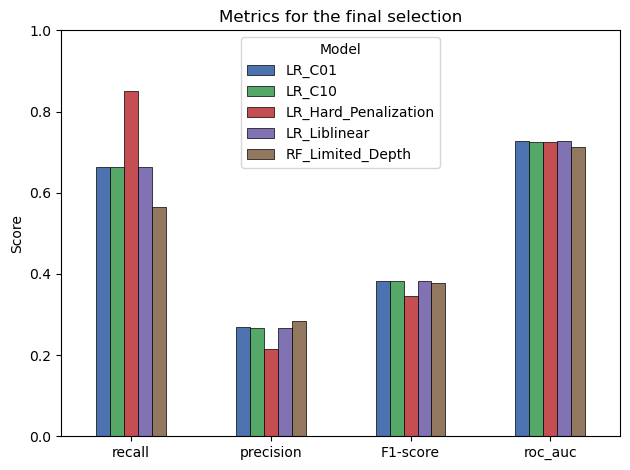

In [13]:
metrics = ["recall", "precision", "F1-score", "roc_auc"]
plot_df = (results[results["model"].isin(options)].set_index("model")[metrics].T  )

colors =  [ "#4C72B0", "#55A868", "#C44E52", "#8172B3", "#937860",]
plt.figure(figsize=(7, 4))
plot_df.plot(kind="bar",color=colors,edgecolor="black", linewidth=0.5)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Metrics for the final selection")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

##### Final Selection
Among the finalist options, the LR_Hard_Penalization configuration is the one that achieves a higher sensitivity, with a recall of 0.85 and a ROC-AUC of 0.73. Although its overall accuracy is lower than the in the most conservatives, such as LR_C01. While this may be a more aggresive model, given the preventive setting of 10-year CHD risk prediction, where failing to indenitfy high-risk patients is consider more harmful than over-estimating risk, this configuration is the best among the ones evaluated. For this reason, LR_Hard_Penalization is selected as the final model. 

### 5. Feature scheme and model export

To complete the validation and model selection process, we input feature scheme expected by the final model and export the selected configuration for downstream deployment. This ensures reproducibility, compatibility, and clarity for future inference steps. 

In [14]:
# Feature Schema -
feature_schema = X.columns.tolist()

print("Feature schema (input order):")
for f in feature_schema:
    print("-",f)

# Save the feature schema as JSON file
with open("../model/feature_schema.json","w") as f:
    json.dump(feature_schema, f, indent=4)

Feature schema (input order):
- sex
- age
- education_level
- current_smoker
- bp_meds
- prevalent_stroke
- prevalent_hypertension
- diabetes
- total_cholesterol
- systolic_bp
- diastolic_bp
- bmi
- heart_rate
- glucose
- smoker_intensity
- pulse_pressure


In [15]:
# Final Model Export 
final_model = LogisticRegression(class_weight={0: 1, 1: 10}, max_iter=1000)
final_model.fit(X,y)

joblib.dump(final_model, "../model/final_model.pkl")

['../model/final_model.pkl']

### Summary - Validation & Model Selection

In this section, a set of 16 models (logistic regression, random forest, SVM and KNN) was evaluated using 5-fold cross-validation to predict 10-year coronary heart disease risk. Model performance was assessed with accuracy, recall, precision, F1-score and ROC-AUC, giving it more importance to sensitivity. Due to the preventive context, where missing high-risk patients is more critical than generating false positives. After comparing model families and focusing on those with acceptable F1-score and ROC-AUC, four finalists were selected. Finally, the LR_Hard_Penalization configuration (logistic regression with increased weight on the positive class) was selected as the final model since is the one with a higher sensitivity while the F1-score and ROC-AUC are not sacrifice, being the better suited. 